<a href="https://colab.research.google.com/github/MakovChen/SideProject-QuantApplication/blob/main/Transformer%E6%96%BC%E6%99%82%E5%BA%8F%E7%9A%84%E6%87%89%E7%94%A8%EF%BC%9A%E4%BB%A5n%E6%97%A5k%E7%B7%9A%E9%A0%90%E6%B8%ACBTC%E7%9A%84%E6%BC%B2%E8%B7%8C%E6%A9%9F%E7%8E%87.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

從yahoo API獲取BTC的每日歷史成交資訊

In [1]:
!pip install mplfinance
import mplfinance as mpf
import yfinance as yf

df = yf.Ticker("BTC-USD").history(period="max")
df

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 2.0 MB/s eta 0:00:00


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,21056800,0.0,0.0
2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,34483200,0.0,0.0
2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,37919700,0.0,0.0
2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,36863600,0.0,0.0
2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,26580100,0.0,0.0
...,...,...,...,...,...,...,...
2023-04-07 00:00:00+00:00,28038.966797,28111.593750,27794.031250,27925.859375,10861680497,0.0,0.0
2023-04-08 00:00:00+00:00,27920.513672,28159.863281,27883.386719,27947.794922,9373255556,0.0,0.0
2023-04-09 00:00:00+00:00,27952.367188,28532.830078,27828.480469,28333.050781,12175322951,0.0,0.0


透過`timestep`設置k線要被分析的window size，並視覺化最後輸入值的類別數。(由於經典Transformer是以Positional Embedding來處理特徵的順序，因此Token必須做離散化)<br>

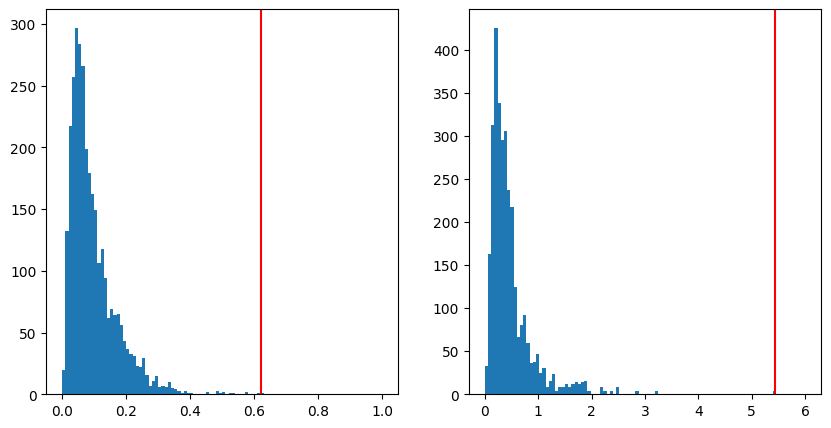

In [2]:
import numpy as np
import matplotlib.pyplot as plt
timestep = 5 # n-day information for Input
ohlc_threads, v_threads = [], [] 
for i in  range(df.shape[0] - timestep):
  series = np.array(df.loc[:, ['Open', 'High', 'Low', 'Close']].iloc[i: i + timestep, :]).flatten()
  ohlc_threads.append(np.max(np.abs(series / series[0] - 1)))
  series = np.array(df.loc[:, ['Volume']].iloc[i: i + timestep, :]).flatten()
  v_threads.append(np.max(np.abs(series[1:]/ series[:-1] - 1)))

#visualization
max_ohlc_thread, max_v_thread = max(ohlc_threads), max(v_threads)
fig = plt.figure(figsize=[10, 5]); ax1 = plt.subplot(121); ax2 = plt.subplot(122)
ax1.hist(ohlc_threads, np.linspace(0, 1, 101))
ax1.plot([max_ohlc_thread, max_ohlc_thread], ax1.set_ylim(), color='red')
ax2.hist(v_threads, np.linspace(0, 6, 101))
ax2.plot([max_v_thread, max_v_thread], ax2.set_ylim(), color='red')

用`角度`將整個window的OHLC和Volume標準化為一個[0, 1, ..., 360]的數值，並整理成X, y。

In [3]:
ohlc_scale_rate = np.pi / max_ohlc_thread
v_scale_rate = np.pi / max_v_thread

threadhold = 0.05
OHLC, V, y, t = [], [], [], []
for i in range(df.shape[0] - timestep):
  j = i + timestep; flag = None
  while j < df.shape[0]:
    if df['High'][j] > df['High'][i + timestep] * (1 + threadhold):
      flag = [0, 1]; break
    elif df['Low'][j] < df['Low'][i + timestep] * (1 - threadhold):
      flag = [1, 0]; break
    j += 1
  if flag != None:
    series = np.array(df.loc[:, ['Open', 'High', 'Low', 'Close']].iloc[i: i + timestep, :]).flatten()
    OHLC.append(np.degrees((series / series[0] - 1) * ohlc_scale_rate).astype(int) + 180 - 1)
    series = np.array(df.loc[:, ['Volume']].iloc[i: i + timestep, :]).flatten()
    V.append(np.degrees((series[1:]/ series[:-1] - 1) * v_scale_rate).astype(int) + 180 - 1)
    y.append(flag)
    t.append(df.index[i + timestep])

OHLC, V, y = np.array(OHLC), np.array(V), np.array(y)
X = np.concatenate((OHLC, V), axis=1)
OHLC.shape, V.shape, X.shape, y.shape

((3121, 20), (3121, 4), (3121, 24), (3121, 2))

建構Transformer的Encoder

In [4]:
import tensorflow as tf
import numpy as np

def positional_encoding(length, depth):
  depth = depth/2
  positions = np.arange(length)[:, np.newaxis]
  depths = np.arange(depth)[np.newaxis, :]/depth
  angle_rates = 1 / (10000**depths)
  angle_rads = positions * angle_rates
  pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], axis=-1) 
  return tf.cast(pos_encoding, dtype=tf.float32)
  
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x
    
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(query=x, value=x, key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([tf.keras.layers.Dense(dff, activation='relu'), tf.keras.layers.Dense(d_model), tf.keras.layers.Dropout(dropout_rate)])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x) 
    return x

class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()
    self.self_attention = GlobalSelfAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)
    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x
    
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1):
    super().__init__()
    self.d_model = d_model
    self.num_layers = num_layers
    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)
    self.enc_layers = [EncoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate) for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    x = self.pos_embedding(x)
    x = self.dropout(x)
    for i in range(self.num_layers):
      x = self.enc_layers[i](x)
    return x 

class Transformer():
  def __init__(self, num_layers = 4, d_model = 24, dff = 512, num_heads = 8, dropout_rate = 0.1, input_vocab_size = 360, target_vocab_size = 2):
    self.X = tf.compat.v1.placeholder(tf.float32, [None, d_model], "X")
    self.y_true = tf.compat.v1.placeholder(tf.float32, [None, target_vocab_size], "X_next")
    output = Encoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff, vocab_size=input_vocab_size, dropout_rate=dropout_rate)(self.X)
    self.output = tf.keras.layers.Flatten()(output)
    self.y_pred = tf.keras.layers.Dense(2, activation='softmax')(self.output)
    self.loss = tf.keras.losses.KLDivergence()(self.y_true, self.y_pred)
    self.train_op = tf.compat.v1.train.AdamOptimizer(1e-4).minimize(self.loss)

tf.compat.v1.disable_eager_execution()
session = tf.compat.v1.InteractiveSession()
transformer = Transformer()
session.run(tf.compat.v1.global_variables_initializer())

開始訓練(保留最後256筆樣本來做驗證並視覺化)

iter - 0 , MSE - 0.16991289


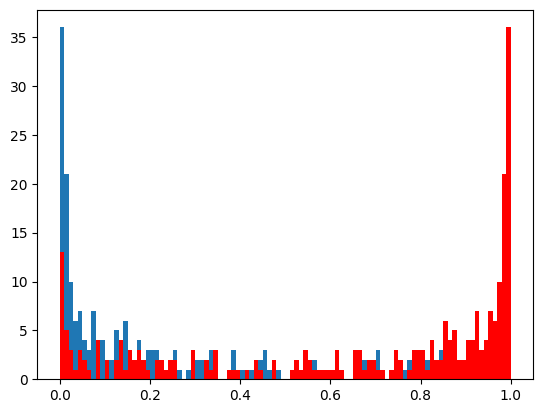

<ipython-input-5-bd7fb0a96d63>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['Volume'][i] = j


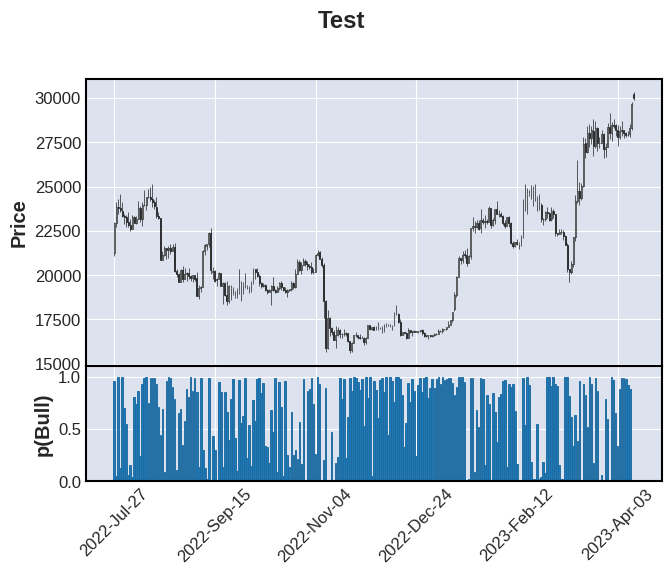

iter - 1 , MSE - 0.0032496685


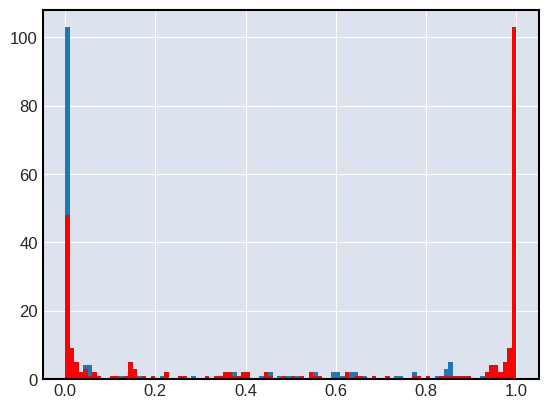

<ipython-input-5-bd7fb0a96d63>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['Volume'][i] = j


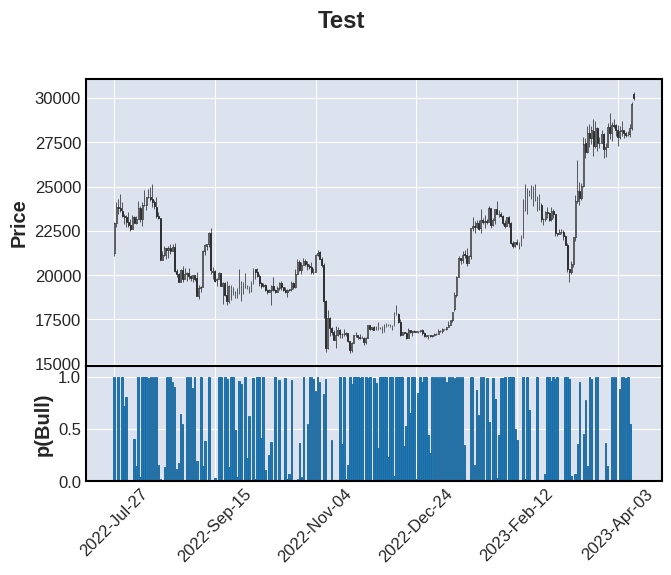

iter - 2 , MSE - 0.00026229312


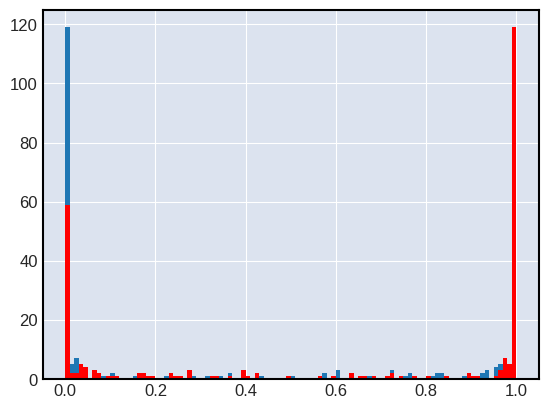

<ipython-input-5-bd7fb0a96d63>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['Volume'][i] = j


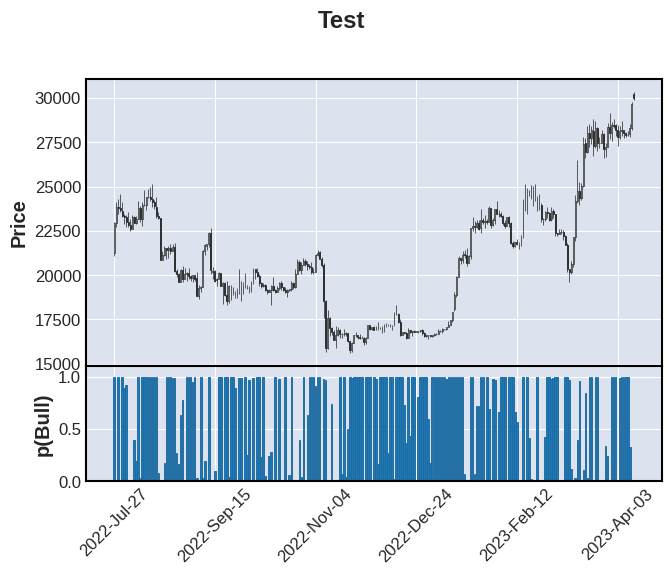

iter - 3 , MSE - 4.069524e-05


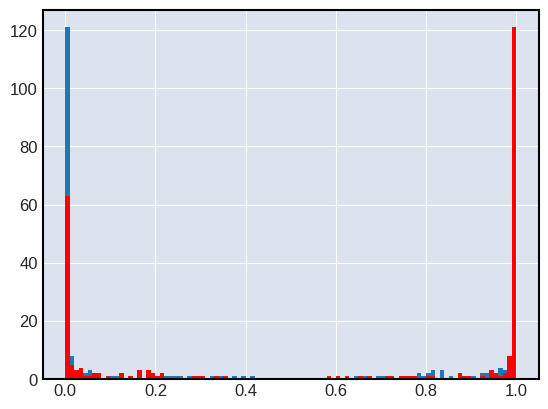

<ipython-input-5-bd7fb0a96d63>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['Volume'][i] = j


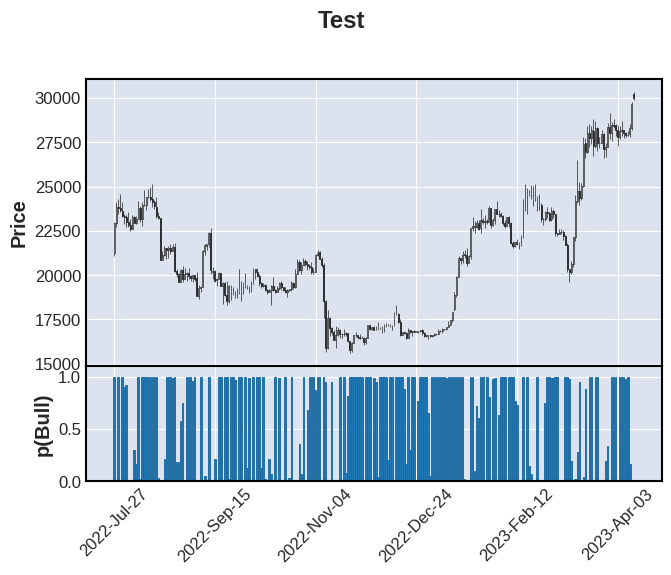

iter - 4 , MSE - 6.3873786e-06


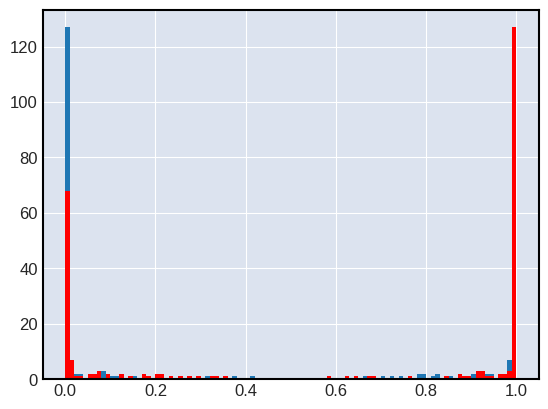

<ipython-input-5-bd7fb0a96d63>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['Volume'][i] = j


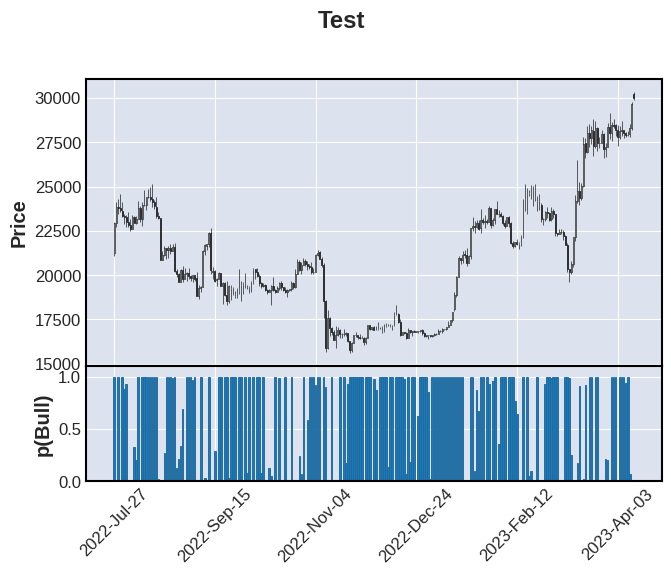

In [5]:
import mplfinance as mpf
for iter in range(5):
    for _ in range(int((X.shape[0]-256))):
      idx = np.random.choice(X.shape[0]-256, size = 256, replace=False)
      _, loss = session.run([transformer.train_op, transformer.loss], {transformer.X: X[idx], transformer.y_true: y[idx]})
    print('iter -', iter,', MSE -', loss)
    y_pred = session.run(transformer.y_pred, {transformer.X: X[-256:], transformer.y_true: y[-256:]})
    plt.hist(y_pred[:,0], np.linspace(0, 1, 101));plt.hist(y_pred[:,1], np.linspace(0, 1, 101), color='red'); plt.show()

    temp_df = df.loc[t[-256]:, :].copy()
    temp_df['Volume'] = 0
    for i, j in zip(t[-256:], y_pred[:,1]):
      temp_df['Volume'][i] = j
    mpf.plot(temp_df,type='candle', title='Test', volume=True, ylabel_lower='p(Bull)'); plt.show()